18.330: Introduction to Numerical Analysis
===

Lecture 1: Invitation
--

This class is all about taking a mathematical expression and turning
it into actual numbers, doing it fast, and knowing how accurate your result is.
Whether you are a physicist, an engineer, a biologist, a chemist, or anyone
who works with mathematical models, it is crucial to be able to use
and understand numerical methods.

The lectures are based primarily on:

* Homer Reid's lecture notes (http://homerreid.com/teaching/18.330/)
* Laurent Demanet's lecture notes (http://math.mit.edu/icg/resources/teaching/18.330/)

An easy problem: Binding energy of an ion
--

Consider infinite chain of ions (for instance, DNA)

... +Q ---- -Q ---- +Q ---- -Q ---- +Q ....

what is the binding energy of one positive ion?
In general, the potential energy of two charged particles is
$$
E = \frac{q_1 q_2}{d},
$$

where $q_1, q_2$ are the charges and d are the distances. Consider the positive ion at the
center of the chain and sum up all the potentials of the neighbors:

$$
E = ...+ \frac{Q Q}{2 d} + \frac{Q (-Q)}{d} + \frac{Q (-Q)}{d} + \frac{Q Q}{2d} + ...
$$

$$
E = \sum_{n=-\infty, n\neq 0}^\infty \frac{(-1)^n Q^2}{|n| d} = 2 \frac{Q^2}{d} \sum_{n=1}^\infty \frac{(-1)^n}{n}
$$

The problem is then to find

$$
S = \sum_{n=1}^\infty \frac{(-1)^n}{n}
$$

First try:

In [1]:
function compute_sum(N)
    S = 0.0

    for i=1:N
        S += (-1)^i/i
    end

    return S
end

compute_sum(10)

-0.6456349206349207

In [2]:
for i in 1:8
    println(compute_sum(10^i))
end

-0.6456349206349207
-0.688172179310195
-0.6926474305598223
-0.6930971830599583
-0.6931421805849816
-0.6931466805602525
-0.6931471305601064
-0.6931471755604192


We found a good solution!
Questions:

* Why did we get 6 digit accuracy around $N\approx 10^8$?
* Can we make this faster?

A harder problem: potential energy of a charge near the charge chain
---

Now consider a charge $q$ at position $(x,y)$ away from the chain.
Its distance from the $n$th charge is
$$
D = \sqrt{(x- n d)^2 + y^2}.
$$

Let's fix $q=Q=d=1$. Then the potential reads:

$$
E(x,y) = \sum_{n=-\infty}^\infty \frac{(-1)^n}{\sqrt{(x- n d)^2 + y^2}}
$$

In [3]:
using PyPlot
PyPlot.svg(true)

""" Compute the electrostatic potential at y=0.1 and x
by naive summation
"""
function compute_potential_naive(x, N, y=0.1)
    s = 0.0
    for i=-N:1:N
        s += (-1)^i/sqrt((i - x)^2 + y^2)
    end
    
    return s
end

compute_potential_naive(0.1, 1000)

5.677075724321494

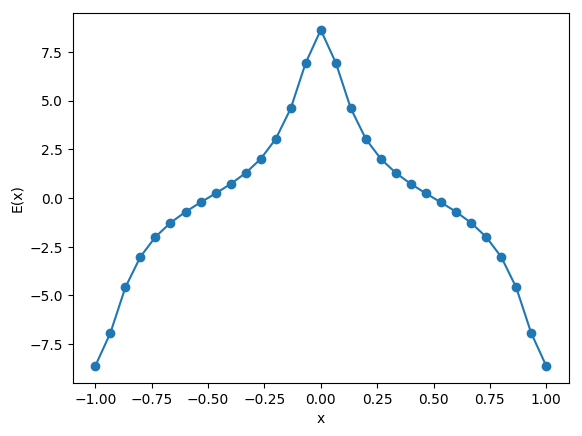

PyObject Text(24.000000000000007, 0.5, 'E(x)')

In [4]:
Exs = LinRange(-1.0, 1.0, 31)
Es = [compute_potential_naive(x, 1000) for x in Exs]

plot(Exs, Es, "o-")
xlabel("x")
ylabel("E(x)")

In [5]:
# "Exact" value

compute_potential_naive(0.25, 10000, 0.25)

1.3986527748610684

We need a lot of iterations for reasonable accuracy. Can we make this better?
--

Realize that the terms in the sum decay rapidly:
--

In [6]:
N = 40
x = 0.25
y = 0.25

for i=0:N
    println((-1)^i/sqrt((x - i)^2 + y^2))
end

2.82842712474619
-1.2649110640673518
0.565685424949238
-0.3621429841700741
0.2660760420950957
-0.2102353324910547
0.17374889710522776
-0.14804664203952106
0.1289651760438322
-0.11423909559550796
0.1025304031702032
-0.09299811099505542
0.0850871259623034
-0.07841629973778232
0.07271525467005983
-0.06778687417315074
0.06348406650689517
-0.05969484389399004
0.05633244101888689
-0.05332859322459773
0.050628855405584566
-0.048189273659093486
0.045973974603236364
-0.04395339016644658
0.04210293065017016
-0.04040197934145309
0.038833121302373125
-0.03738154508127982
0.036034573742285116
-0.03478129373775912
0.03361225860937662
-0.032519250488692565
0.03149508665761988
-0.0305334615402149
0.029628816778865318
-0.02877623373890056
0.027971344051002624
-0.027210254756352414
0.026489485347245486
-0.02580591455471325
0.025156735166994963


Pairs decay even faster
---

In [7]:
for i=0:2:N
    println(1/sqrt((x - i)^2 + y^2) - 1/sqrt((x - i - 1)^2 + y^2))
end

1.563516060678838
0.2035424407791639
0.05584070960404103
0.025702255065706697
0.014726080448324241
0.009532292175147783
0.006670826224521087
0.004928380496909093
0.0037892226129051312
0.003003847794289159
0.0024395817464910804
0.0020205844367897838
0.001700951308717065
0.0014515762210933064
0.0012532800045259931
0.0010930081206840525
0.0009616251174049822
0.0008525830399647577
0.00076108929465021
0.0006835707925322357
0.0006173196674391125


Idea:
---

We split the sum into terms 

$$
V(x,y) = V_{local}(x,y) + V_{distant}(x,y)
$$

with

$$
V_{local}(x,y) = \sum_{|n| < N} \frac{(-1)^n}{\sqrt{(x- n d)^2 + y^2}}
$$

$$
V_{distant}(x,y) = \sum_{|n| \geq N} \frac{(-1)^n}{\sqrt{(x- n d)^2 + y^2}}
$$

In [8]:
function V_local(x, y, N)
    s = 0.0
    for i=-N:1:N
        s += (-1)^i/sqrt((i - x)^2 + y^2)
    end
    
    return s
end

function V_distant(x, y, N, M)
    s = 0.0
    for i=N:M
        s += (-1)^i/sqrt((i - x)^2 + y^2) + (-1)^(-i)/sqrt((-i - x)^2 + y^2)
    end
    
    return s
end

V_distant (generic function with 1 method)

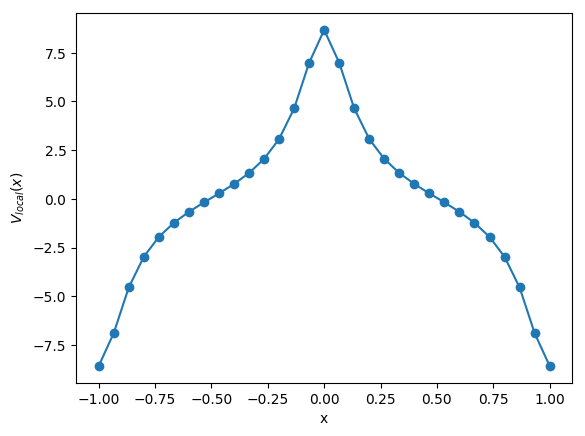

PyObject Text(27.39999999999999, 0.5, '$V_{local}(x)$')

In [9]:
xs = LinRange(-1.0, 1.0, 31)
V_locals = [V_local(x, 0.1, 20) for x in xs]

plot(xs, V_locals, "o-")
xlabel("x")
ylabel(L"V_{local}(x)")

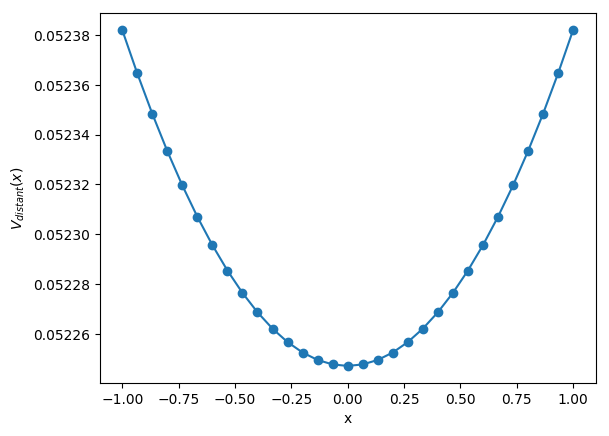

PyObject Text(27.400000000000006, 0.5, '$V_{distant}(x)$')

In [10]:
xs = LinRange(-1.0, 1.0, 31)
V_locals = [V_distant(x, 0.1, 20, 1000) for x in xs]

plot(xs, V_locals, "o-")
xlabel("x")
ylabel(L"V_{distant}(x)")

Ewald summation
---

$V_{local}$ is rapidly decaying in real space, so it converges very quickly.
Similarly, $V_{distant}$ is almost constant, so it converges rapidly in Fourier space!
(Remember that the FT of a constant function is a Dirac $\delta$ function).

So: Fourier transform $V_{distant}$ to evaluate the sum, then recombine to
obtain highly efficient numerical method.

In practice (with more bells and whistles), Ewald summation can achieve
extremely high accuracy in very few ($\mathcal{O}(10)$) iterations.
Compare that to the thousands we needed using the naive method!

Example of the power of /spectral methods/ (will see this in the remainder of the class).

Problems involving integrals: Potential near a continuous charge density
---

Strip of length $L$ with charge density $\lambda(x)$. The electrostatic potential becomes

$$
V(x,y) = \int_{-L/2}^{L/2} dx' \frac{\lambda(x)}{\sqrt{(x-x')^2 + y^2}}
$$

Suppose $L=20$ and $\lambda(x) = \cos(x^2)$.

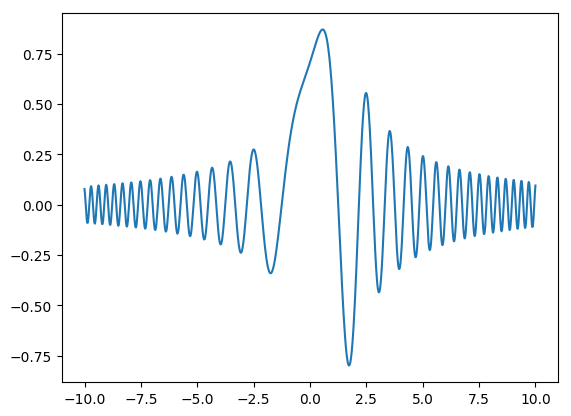

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f1efd7b4390>

In [11]:
x = 1
y = 1

L = 20

xprimes = LinRange(-L/2, L/2, 1000)

V(x, y, xprime) = cos.(xprime.^2) ./ sqrt.((xprime .- x).^2 .+ y.^2)

pots = V(x, y, xprimes)

plot(xprimes, pots)

How do we evaluate this integral?
Naive method: Riemann sum (just like in the definition!)

$$
I = \int_a^b f(x)\, dx = \text{area of many rectangles under the graph}
$$

We can formalize this by choosing a rectangle base length $\Delta = (b-a)/N$:

$$
    I_N^{\text{rect}} = \sum_{i=1}^N \Delta \cdot f(a + i \Delta)
$$

In [12]:
function rectangular_rule(f, a, b, N)
    I = 0.0
    Δ = (b - a)/N
    
    for i=1:N
        I += Δ * f(a + i*Δ)
    end
    
    return I
end

rectangular_rule (generic function with 1 method)

In [13]:
rectangular_rule(xp -> V(1, 1, xp), -L/2, L/2, 1000)

0.948552026628988

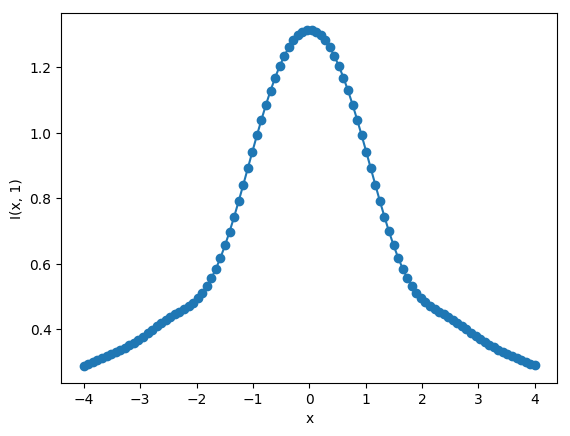

PyObject Text(24.000000000000007, 0.5, 'I(x, 1)')

In [14]:
xs = LinRange(-4, 4, 100)
y = 0.1

Is = [rectangular_rule(xp -> V(x, 1, xp), -L/2, L/2, 1000) for x in xs]

plot(xs, Is, "o-")
xlabel("x")
ylabel("I(x, 1)")

How accurate is the rectangular rule? We compare with the exact solution obtained using Mathematica:
V(1,1) "=" 0.9483130210697331

In [15]:
I_exact = 0.9483130210697331
Ns = [10^i for i=2:7]

errors = [(rectangular_rule(xp -> V(1, 1, xp), -L/2, L/2, N) - I_exact)/I_exact for N in Ns]

6-element Array{Float64,1}:
 0.012151986302681488  
 0.00025203235002005576
 1.8800874249367533e-5 
 1.8162531865734111e-6 
 1.809870068422949e-7  
 1.8092330692942616e-8 

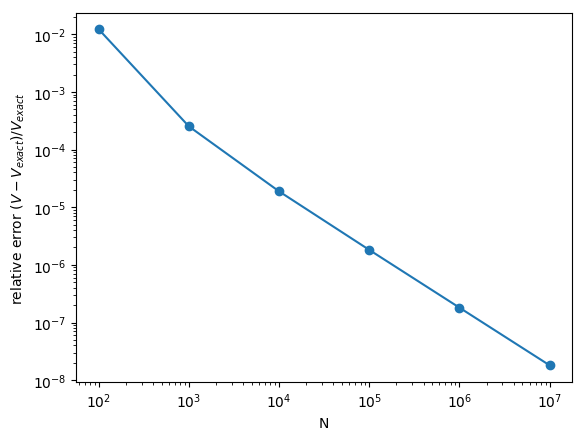

PyObject Text(27.400000000000006, 0.5, 'relative error $(V - V_{exact})/V_{exact}$')

In [16]:
loglog(Ns, errors, "o-")
xlabel("N")
ylabel(L"relative error $(V - V_{exact})/V_{exact}$")

The slope on the log-log plot is -1: The rectangular rule is a first-order method: slow!
For each additional correct digit you need to do 10 times as many computations!

Much better methods exist.

Important questions:

* What happens with infinite integration ranges?
* What happens with singularities?
* Why is the rectangular rule first-order?
* Are there better methods? (Hint: yes and we will discuss them)

Sneak Peak: A general trick is to use unevenly spaced evaluation points
---

Calculating Derivatives: Finite differences
---

Remember that for a given potential $V(x,y)$, the electric field is

$$
    \vec E = -\vec\nabla V
$$

How do we take a derivative of this? 
Remember the definition:

$$
f'(x) = \lim_{h\rightarrow 0} \frac{f(x+h) - f(x)}{h}
$$

A finite difference approximation takes $h$ finite:

$$
f^{FD}_h(x) = \frac{f(x+h) - f(x)}{h}
$$

Let's try this out with $f(x) = x^2$. We know $f'(x) = 2x$.

In [17]:
f(x) = x.^2
fprime(x) = 2 .*x

function finite_diff(f, x0, h)
    return (f(x0 + h) - f(x0))/h
end

finite_diff (generic function with 1 method)

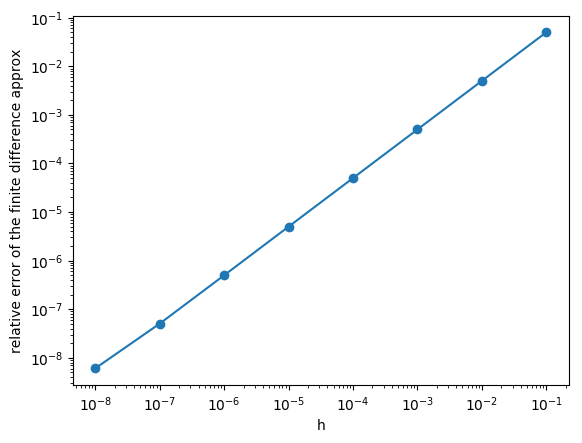

PyObject Text(24.00000000000002, 0.5, 'relative error of the finite difference approx')

In [18]:
hs = [10.0^(-i) for i=1:8] # then: to 15

rel_errors = [abs((finite_diff(f, 1, h) - fprime(1))/fprime(1)) for h in hs]

loglog(hs, rel_errors, "o-")

xlabel("h")
ylabel("relative error of the finite difference approx")

* Why is the convergence linear?
* Can we do better (hint: yes and we will see how)
* Why does the finite difference break down beyond $h=10^{-8}$?

Solving equations of motion: Integration of ODEs
---

Using the electric field from the previous example we can ask:
What is the motion of a charged particle of mass $m$ and charge "q" in that field?
The trajectory will be a solution of Newton's equation

$$
m \ddot{x}(t) = q\, E(x(t)).
$$

The basic numerical method for solving this is to fix initial conditions
$x(t_0), \dot{x}(t_0)$, compute the new position and velocity
$x(t_0 + \Delta t), \dot{x}(t_0 + \Delta t)$ using a finite difference version
of the equations of motion, and repeat. Actually, all state of the art
ODE solvers will be of this type!

This solves an initial value problem (IVP).
A similar problem is the boundary value problem (BVP), where 
$x(t_0)$ and $x(t_1)$ are known, and we need to find the trajectory in between
that satisfies the equations of motion.
We will discuss methods for this later in the class.

Root finding
---

At rest after a long time, our charged particle will satisfy

$$
0 = E(x).
$$

This is a root finding problem. A classical way to solve this is
Newton's method:

* Guess a solution $x_0$
* Compute $E(x_0)$ and $E'(x_0)$
* Compute $x_1 = x_0 - E(x_0)/E'(x_0)$
* Repeat

Problem: Newton's method may be very sensitive to the initial guess

In [19]:
# Example

f(x) = tanh(x - 5)
fprime(x) = 1 - (tanh(x-5))^2

# this guess leads to the correct solution
x = 4.1

# this guess does not
# x = 0

# Newton iteration
for i=1:6
    x = x - f(x)/fprime(x)
    println(x)
end

5.571087144047841
4.867474679505301
5.001557150903486
4.999999997482897
5.0
5.0


For functions with multiple roots, it can also be very hard to tell which one
Newton's method will converge to

In [20]:
# Example

f(x) = 1 - x^3
fprime(x) = -3x^2

# this guess converged to 1
x = 0.1

# this guess does not
# x = 0.1 + 0.1im

# Newton iteration
for i=1:20
    x = x - f(x)/fprime(x)
    println(x)
end

33.39999999999999
22.266965470257084
14.845315936873035
9.898389806825493
6.6023286579766065
4.409199322025365
2.95661207500204
2.0092067577957806
1.4220425408243893
1.112864930197824
1.0110596112359882
1.000120535933774
1.0000000145265766
1.0000000000000002
1.0
1.0
1.0
1.0
1.0
1.0


![](newton_fractal.png)

The Newton fractal for $f(x) = 1 - x^3$. Color corresponds to the solution the iteration converged to.

Interpolation
---

What if we want to work with functions that come from data points but we
need exact derivatives (or want speed).
The solution can be approximation by interpolation.

We find (few) simple functions that approximate our data. For example, polynomials.

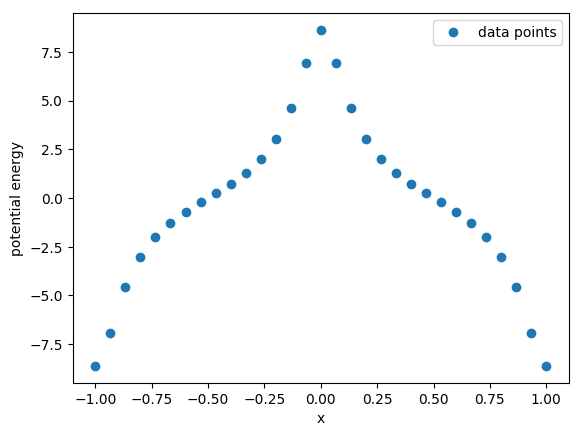

PyObject <matplotlib.legend.Legend object at 0x7f1efcf2ea20>

In [21]:
# Let's take our potential energies from before
plot(Exs, Es, "o", label="data points")

xlabel("x")
ylabel("potential energy")
legend()

In [22]:
# polynomial interpolation
using Polynomials

p9 = polyfit(Exs, Es, 9)
p20 = polyfit(Exs, Es, 20)
p24 = polyfit(Exs, Es, 24)

Poly(8.406277587886498 - 4.468501448340705e-8*x - 332.51690245018557*x^2 + 2.576670687257347e-6*x^3 + 8591.592151040697*x^4 - 7.287514508851883e-5*x^5 - 131434.47572684602*x^6 + 0.0009712289357224286*x^7 + 1.2245532826533774e6*x^8 - 0.006827463671346565*x^9 - 7.29966506771179e6*x^10 + 0.02753975486299299*x^11 + 2.8830398653750375e7*x^12 - 0.06617943800910496*x^13 - 7.686762408261824e7*x^14 + 0.09363255630571726*x^15 + 1.386833513520085e8*x^16 - 0.07064189496497925*x^17 - 1.66515478058755e8*x^18 + 0.016885896083550476*x^19 + 1.2718817652013157e8*x^20 + 0.009986347946163333*x^21 - 5.581630155443296e7*x^22 - 0.00529663000886355*x^23 + 1.0695747327526057e7*x^24)

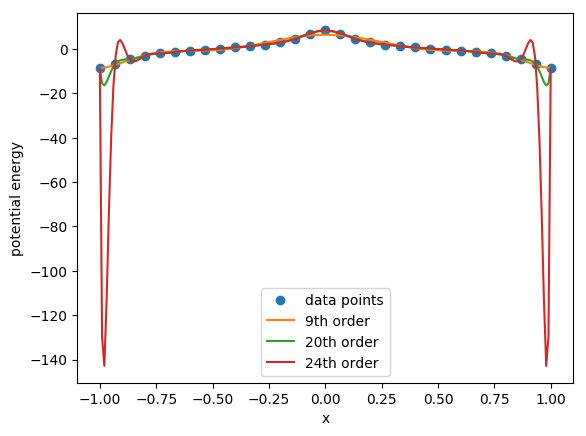

PyObject <matplotlib.legend.Legend object at 0x7f1efcf48080>

In [25]:
# plot the interpolation polynomial
xs = LinRange(-1, 1, 200)
plot(Exs, Es, "o", label="data points")
plot(xs, polyval(p9, xs), label="9th order")
plot(xs, polyval(p20, xs), label="20th order")
plot(xs, polyval(p24, xs), label="24th order")

xlabel("x")
ylabel("potential energy")
legend()

Runge's phenomenon
--
As we increase the order of the interpolation polynomial, it appears to
"bulge out" more and more.

* What is the "right" order of polynomial? Does polynomial interpolation even work at all?
* Can we get rid of Runge's phenomenon/improve polynomial interpolation?